Installation

In [1]:
!pip install -U "ray[rllib]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.8 MB/s eta 0:00:00


Colab mount

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

os.chdir('/content/drive/MyDrive/Colab Notebooks/rllib')

Import libraries

In [4]:
import pickle
import numpy as np
import random
from scipy import odr
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium.wrappers import NormalizeObservation
from gymnasium.wrappers import NormalizeReward

import os
import ray
from ray import train, tune, air
from ray.rllib.algorithms.sac.sac import SACConfig
from ray.tune import ResultGrid
from ray.tune.logger import pretty_print
from ray.tune.registry import get_trainable_cls
from ray.tune.registry import register_env

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [5]:
import easydict

args = easydict.EasyDict({
    'run': 'SAC',
    'stop_iters': 500,
    'stop_timesteps': 100000,
    'stop_reward': 30,
    'framework': 'torch'
})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
version = 'baseline'
base_tmp_folder = './result'
direcrory = base_tmp_folder+'/models/'
model_dir = direcrory + version
model_path = model_dir + '/model/'
scaler_dir = model_dir + '/scaler/'

env_config = easydict.EasyDict({
    'model1_dir': model_path+'simulator_greenhouse.pkl',
    'model2_dir': model_path+'simulator_crop_front.pkl',
    'model3_dir': model_path+'simulator_crop_back.pkl',
    'scaler1_x': scaler_dir+'greenhouse_x_scaler.pkl',
    'scaler1_y': scaler_dir+'greenhouse_y_scaler.pkl',
    'scaler2_x': scaler_dir+'crop_front_x_scaler.pkl',
    'scaler2_y': scaler_dir+'crop_front_y_scaler.pkl',
    'scaler3_x': scaler_dir+'crop_back_x_scaler.pkl',
    'scaler3_y': scaler_dir+'crop_back_y_scaler.pkl',
    'linreg_dir': model_path+'PARsensor_regression_parameters.pkl',
    'weather_dir': model_path+'weather.npy'
})

Network

In [7]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=120):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        return x

Economic model

In [8]:
class Economic:
    def __init__(self, dayAction, dayState, dayReward):
        self.dayAction = dayAction  # [heating temp, ventilation, lamps, scr_enrg, scr_blck, co2]
        self.dayState = dayState  # [AirT, AirRH, Airppm]
        self.dayReward = dayReward  # [FW]

    def cal_economic(self):

        gains = self.cal_gains()
        elecCost = self.elec_cost()
        co2Cost = self.co2_cost()
        heatCost = self.heat_cost()

        variableCosts = elecCost + co2Cost + heatCost
        balance = gains - variableCosts
        # balance = gains

        economic = {'balance': balance,
                    'gains': gains,
                    'variableCosts': variableCosts,
                    'elecCost': elecCost,
                    'co2Cost': co2Cost,
                    'heatCost': heatCost}

        return economic

    def cal_gains(self):
        # price = 3.5
        price = 3.185
        # price = 3.1
        # price = 2.94
        return self.dayReward[0] * price

    def elec_cost(self):
        lmp_use = self.dayAction[:, 2]
        days = len(lmp_use) // 24

        power = 185 / 2.1

        price = np.array(([0.04] * 7 + [0.08] * 16 + [0.04] * 1) * days)
        cost = np.sum(np.array(lmp_use) * price * power / 1000)

        return cost

    def co2_cost(self):
        CO2_setpoint = self.dayAction[:, 5]
        Airppm = self.dayState[:, 2]

        McConAir_max = 4e-6
        co2_use = CO2_setpoint - Airppm
        co2_use[co2_use > 0] = McConAir_max
        co2_use[co2_use <= 0] = 0

        price1, price2 = 0.08, 0.2
        kgCO2 = sum(co2_use) * 3600
        firstTranche = min(kgCO2, 12)
        secondTranche = kgCO2 - firstTranche
        cost = firstTranche * price1 + secondTranche * price2

        return cost

    def heat_cost(self):
        temp_setpoint = self.dayAction[:, 0]
        AirT = self.dayState[:, 0]

        PConPipe1_max = np.full((24), 60)
        heat_use = (PConPipe1_max - AirT) * 2.1

        heat = temp_setpoint - AirT
        heat_use[heat <= 0] = 0

        price = 0.03
        cost = sum(heat_use) * price / 1000

        return cost

Environment

In [9]:
class GreenhouseEnv(gym.Env):

    def __init__(self, config):
        self.net1 = Net(14, 3, 300)
        self.net1.load_state_dict(torch.load(
            config['model1_dir'], map_location=torch.device('cpu')))
        self.net2 = Net(5, 1, 300)
        self.net2.load_state_dict(torch.load(
            config['model2_dir'], map_location=torch.device('cpu')))
        self.net3 = Net(2, 1, 600)
        self.net3.load_state_dict(torch.load(
            config['model3_dir'], map_location=torch.device('cpu')))
        self.net1.eval()
        self.net2.eval()
        self.net3.eval()

        self.scaler1_x = pickle.load(open(config['scaler1_x'], 'rb'))
        self.scaler1_y = pickle.load(open(config['scaler1_y'], 'rb'))
        self.scaler2_x = pickle.load(open(config['scaler2_x'], 'rb'))
        self.scaler2_y = pickle.load(open(config['scaler2_y'], 'rb'))
        self.scaler3_x = pickle.load(open(config['scaler3_x'], 'rb'))
        self.scaler3_y = pickle.load(open(config['scaler3_y'], 'rb'))

        self.linreg = pickle.load(open(config['linreg_dir'], 'rb'))

        self.full_weather = np.load(config['weather_dir'])

        self.observation_space = self.observation_space()
        self.action_space = self.action_space()

        self.reset()

        self._max_episode_steps = 48

    def observation_space(self):
        # AirT * 24, AirRH * 24, Airppm * 24; GR; FW
        low = np.concatenate(([0 for _ in range(24)], [0 for _ in range(24)],
                               [0 for _ in range(24)], [0, 0]))
        high = np.concatenate(([40 for _ in range(24)], [100 for _ in range(24)],
                                [6000 for _ in range(24)], [10, 300]))
        return Box(low=low, high=high, dtype=np.float32)

    def action_space(self):
        # heating temp, ventilation, lamps, scr_enrg, scr_blck, co2
        low = np.concatenate(
            ([0 for _ in range(24)], [0 for _ in range(24)], [0 for _ in range(24)], [0 for _ in range(24)],
             [0 for _ in range(24)], [0 for _ in range(24)]))
        high = np.concatenate(
            ([40 for _ in range(24)], [1 for _ in range(24)], [1 for _ in range(24)], [1 for _ in range(24)],
             [1 for _ in range(24)], [6000 for _ in range(24)]))

        return Box(low=low, high=high, dtype=np.float32)

    def f_co2(self, co2):
        beta_co2 = 400
        return 1 - np.exp(-co2 / beta_co2)

    def f_par(self, par):
        beta_par = 200
        return 1 - np.exp(-par / beta_par)

    def f_t(self, t):
        t_opt = 25
        t_diff = np.abs(t - t_opt)
        t_rng = 25
        if t_diff < t_rng:
            return 1 - (t_diff / t_rng) ** 2
        else:
            return 0

    def g(self, co2, par, t, fw, d, h):
        day_fw = fw[d*24:(d+1)*24]
        cum_gr_t = ((day_fw[h] + 1)/(day_fw[0] + 1)) ** (1/(h+1)) - 1
        hour_gr = 1.194 ** (1 / 12)
        max_gr = np.array([hour_gr, cum_gr_t], dtype=object)
        max_gr = np.min(max_gr)
        co2_r = self.f_co2(co2)
        par_r = self.f_par(par)
        t_r = self.f_t(t)
        return max_gr * co2_r * par_r * t_r

    def get_outside_weather(self, day_index):
        if day_index < 48:
            return self.full_weather[day_index * 24:(day_index + 1) * 24]
        else:
            mv_idx = day_index - 48
            return self.full_weather[(day_index - mv_idx) * 24:(day_index + 1-mv_idx) * 24]

    def calculate_reward(self, dayAction, dayState, dayReward):
        economic = Economic(dayAction=dayAction, dayState=dayState,
                            dayReward=dayReward).cal_economic()
        reward = economic['balance']

        return reward, economic

    def crop_weight(self, t):
        cm = 20
        rm = 0.14
        tb = 35.4
        w = cm/rm*np.log(1+np.exp(rm*(t-tb)))
        return w

    def poly_fw(self):
        days = 48
        d = np.array(range(days))

        days_fw = self.crop_weight(d)
        fw_model = odr.polynomial(5)
        FW = odr.Data(d, days_fw)
        odr_fw = odr.ODR(FW, fw_model)
        output = odr_fw.run()  # running ODR fitting
        poly = np.poly1d(output.beta[::-1])
        return poly(np.linspace(0, days, days * 24)).reshape(-1, 1)

    def _get_obs(self):
        observation = np.hstack((self.day_inside_weather, self.crop_state, self.fw))
        return observation

    def step(self, action):
        assert len(action) == 144, 'wrong input control dimension'

        # self.action = action

        action = action.reshape((6, 24)).T

        day_outside_weather = self.get_outside_weather(self.day_index)

        day_inside_weather = np.zeros((24, 3))

        cum_gr = 1  # cumulative growth rate

        days_fw = self.poly_fw()

        for i in range(24):
            # each hour
            # Tout, Rhout, Iglob, Windsp, PARout
            cur_outside_weather = day_outside_weather[i]
            cur_control = action[i]  # temp, vent, lamp, scr_enrg, scr_black, co2
            cur_inside_weather = self.inside_weather  # Tair, Rhair, CO2air
            day_inside_weather[i, :] = cur_inside_weather
            input1 = np.hstack(
                (cur_outside_weather, cur_control, cur_inside_weather))
            input1 = input1.reshape(1, -1)
            # input1 = input1.repeat(5,axis=0)
            input1_normal = self.scaler1_x.transform(input1)
            input1_normal = torch.tensor(input1_normal, dtype=torch.float)
            output1_normal = self.net1(input1_normal).detach().numpy()
            # output1_normal = output1_normal.reshape(1,-1)
            output1 = self.scaler1_y.inverse_transform(output1_normal)[0]
            output1 = np.clip(output1, [0, 0, 0], [40, 100, 6000])
            self.inside_weather = output1

            # PARsensor calculation
            PARsensor = self.linreg.predict(input1[0, [2, 4, 7]].reshape(1, -1))
            PARsensor = PARsensor if PARsensor > 50.0 else 0.0
            # PARsensor = np.array(PARsensor)
            # PARsensor = PARsensor.reshape(1,-1)

            # input2 = np.hstack(
            #     (self.inside_weather, PARsensor, self.crop_state))
            # # print(input2)
            # input2 = input2.reshape(1, -1)
            # input2_normal = self.scaler2_x.fit_transform(input2)
            # input2_normal = torch.tensor(input2_normal, dtype=torch.float)
            # output2_normal = self.net2(input2_normal).detach().numpy()
            # output2 = self.scaler2_y.inverse_transform(output2_normal)[0]

            # output2[-1] = np.maximum(self.crop_state[-1], output2[-1])

            # self.crop_state = output2  # LAI, PlantLoad, NetGrowth
            # print(self.inside_weather)
            # print(self.crop_state)

            gr = self.g(co2=output1[2],
                        par=PARsensor,
                        t=output1[0],
                        fw=days_fw,
                        d=self.day_index,
                        h=i)
            cum_gr *= (1 + gr)

        # input3 = np.concatenate((self.crop_state, self.fw))
        # # print(input3)
        # input3 = input3.reshape(1, -1)
        # input3_normal = self.scaler3_x.transform(input3)
        # input3_normal = torch.tensor(input3_normal, dtype=torch.float)
        # output3_normal = self.net3(input3_normal).detach().numpy()
        # output3 = self.scaler3_y.inverse_transform(output3_normal)[0]
        #
        # cur_fw = self.fw
        #
        # output3 = output3 if output3 > 0.1 else np.array([0])
        # output3 = np.maximum(output3, self.fw)
        # self.fw = output3
        # print('fw', self.fw)

        # day_fw = (self.fw - cur_fw) + self.store_fw
        # harvest = 1e-3
        # if day_fw < harvest:
        #     self.store_fw += self.fw - cur_fw
        #     day_fw = np.zeros(1)
        #
        # else:
        #     self.store_fw = np.zeros(1)

        cur_fw = self.fw.copy()
        self.fw *= cum_gr
        day_fw = self.fw - cur_fw

        reward, economic = self.calculate_reward(
            dayAction=action, dayState=day_inside_weather, dayReward=day_fw)

        self.day_inside_weather = day_inside_weather.T.reshape(1, -1)[0]
        obs = self._get_obs()

        self.day_index += 1

        done = self.day_index >= self._max_episode_steps

        return obs, reward, done, False, economic

    def reset(self, seed=None, options=None):
        random.seed(seed)

        self.inside_weather = np.array([17.27, 61.83, 737.31])
        self.day_inside_weather = np.concatenate((np.random.randint(20, 24, 24),
                                                  np.random.randint(50, 80, 24),
                                                  np.random.randint(600, 800, 24)))

        self.crop_state = np.zeros(1)

        self.fw = np.ones(1)

        self.store_fw = np.zeros(1)

        self.day_index = 0

        observation = self._get_obs()

        return observation, {}

Register the custom env

In [10]:
# Register the custom env
def env_creator(env_config):
    env = GreenhouseEnv(env_config)
    # env = NormalizeObservation(env)
    env = NormalizeReward(env)
    return env

register_env("greenhouse", env_creator)

Ray rllib SAC

In [10]:
storage_path = '/content/drive/MyDrive/Colab Notebooks/rllib/ray_results'

if not os.path.exists(storage_path):
    os.makedirs(storage_path)

# actor_learning_rate': tune.grid_search([0.01, 0.001, 0.0001])
# exp_name = 'SAC2'

# critic_learning_rate': tune.grid_search([0.01, 0.001, 0.0001])
exp_name = 'SAC2_critic_lr'

In [12]:
ray.init()

config = (
        get_trainable_cls(args.run)
        .get_default_config()
        .environment("greenhouse", env_config=env_config)
        # .environment(GreenhouseEnv, env_config=env_config)
        .framework(args.framework)
        .rollouts(num_rollout_workers=1,
                  observation_filter='MeanStdFilter')
        # Use GPUs iff `RLLIB_NUM_GPUS` env var set to > 0.
        .resources(num_gpus=int(os.environ.get("RLLIB_NUM_GPUS", "0")))
        .training(
            gamma=0.95,
            target_network_update_freq=32,
            tau=1.0,
            train_batch_size=32,
            optimization_config={'actor_learning_rate': 0.005,
                                 'critic_learning_rate': 0.005,
                                 'entropy_learning_rate': 0.0001}
        )
    )

stop = {
    'training_iteration': args.stop_iters,
    # 'timesteps_total': args.stop_timesteps,
    'episode_reward_mean': args.stop_reward
}

# automated run with Tune and grid search and TensorBoard
print("Training automatically with Ray Tune")
tuner = tune.Tuner(
    args.run,
    param_space=config.to_dict(),
    run_config=train.RunConfig(
        name=exp_name,
        stop=stop,
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute='episode_reward_mean',
            num_to_keep=5
        ),
        storage_path=storage_path
    )
)
results_grid: ResultGrid = tuner.fit()

2024-02-08 09:01:49,883	INFO worker.py:1724 -- Started a local Ray instance.
/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
2024-02-08 09:01:51,496	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information,

Training automatically with Ray Tune
+--------------------------------------------------------+
| Configuration for experiment     SAC_e_500             |
+--------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator |
| Scheduler                        FIFOScheduler         |
| Number of trials                 1                     |
+--------------------------------------------------------+

View detailed results here: /content/drive/MyDrive/Colab Notebooks/rllib/ray_results/SAC_e_500
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/SAC_e_500`

Trial status: 1 PENDING
Current time: 2024-02-08 09:01:51. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+---------------------------------------+
| Trial name                   status   |
+---------------------------------------+
| SAC_greenhouse_b2dec_00000   PENDING  |
+---------------------------------------+


(pid=1128) /usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
(pid=1128)   warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
(pid=1128) /usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
(pid=1128) Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
(pid=1128)   declare_namespace(pkg)
(pid=1128) /usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
(pid=1128) Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/refe


Trial SAC_greenhouse_b2dec_00000 started with configuration:
+---------------------------------------------------------------------------+
| Trial SAC_greenhouse_b2dec_00000 config                                   |
+---------------------------------------------------------------------------+
| _AlgorithmConfig__prior_exploration_config                                |
| _deterministic_loss                                                 False |
| _disable_action_flattening                                          False |
| _disable_execution_plan_api                                          True |
| _disable_initialize_loss_from_dummy_batch                           False |
| _disable_preprocessor_api                                           False |
| _enable_new_api_stack                                               False |
| _fake_gpus                                                          False |
| _is_atari                                                                 |
| 

(SAC pid=1128) Trainable.setup took 17.724 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(SAC pid=1128) Install gputil for GPU system monitoring.



Trial status: 1 RUNNING
Current time: 2024-02-08 09:02:21. Total running time: 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------+
| Trial name                   status   |
+---------------------------------------+
| SAC_greenhouse_b2dec_00000   RUNNING  |
+---------------------------------------+
Trial status: 1 RUNNING
Current time: 2024-02-08 09:02:51. Total running time: 1min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)     ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(SAC pid=1128) 2024-02-08 09:03:08,176	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!


Trial status: 1 RUNNING
Current time: 2024-02-08 09:03:21. Total running time: 1min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                   status       iter     total time (s)     ts     reward     episode_reward_max     episode_reward_min     episode_len_mean     episodes_this_iter |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| SAC_greenhouse_b2dec_00000   RUNNING        16             57.768   1600    4.09806                14.6654                2.19684                   48                      2 |
+----------------------------------------------------------------------------------------------------------------------------------------------------------

(SAC pid=1128) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/Colab Notebooks/rllib/ray_results/SAC_e_500/SAC_greenhouse_b2dec_00000_0_2024-02-08_09-01-51/checkpoint_000000)


In [ ]:
ray.shutdown()

Load learned model

In [13]:
experiment_path = os.path.join(storage_path, exp_name)
print(f"Loading results from {experiment_path} ...")

restored_tuner = tune.Tuner.restore(experiment_path, trainable="SAC")
result_grid = restored_tuner.get_results()

Loading results from /content/drive/MyDrive/Colab Notebooks/rllib/ray_results/SAC2 ...


In [14]:
# Check if there have been errors
if result_grid.errors:
    print("One of the trials failed")
else:
    print("No errors!")

No errors!


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
num_results = len(result_grid)
print("Number of results:", num_results)

Number of results: 3


In [16]:
result = result_grid[0]
result_df = result.metrics_dataframe
result_df[["training_iteration", "episode_reward_mean", "time_total_s"]]

,training_iteration,episode_reward_mean,time_total_s
0,1,9.545827,3.267954
1,2,6.657088,6.454150
2,3,5.730966,10.408123
3,4,5.203999,13.274599
4,5,4.924763,16.156505
...,...,...,...
495,496,3.790953,4380.272217
496,497,3.790910,4388.904765
497,498,3.790867,4398.044017
498,499,3.790824,4407.706776


Visualize actor loss

<Axes: xlabel='training_iteration'>

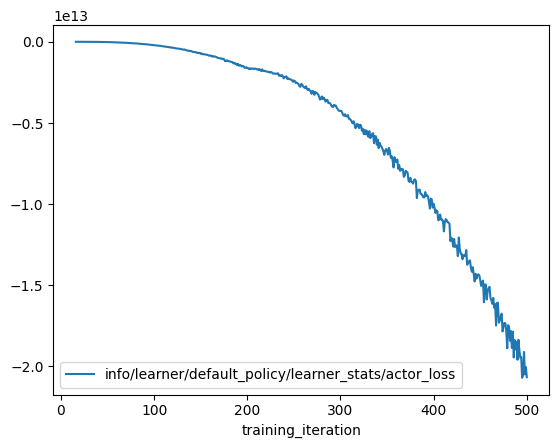

In [18]:
result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/actor_loss")

Visualize critic loss

<Axes: xlabel='training_iteration'>

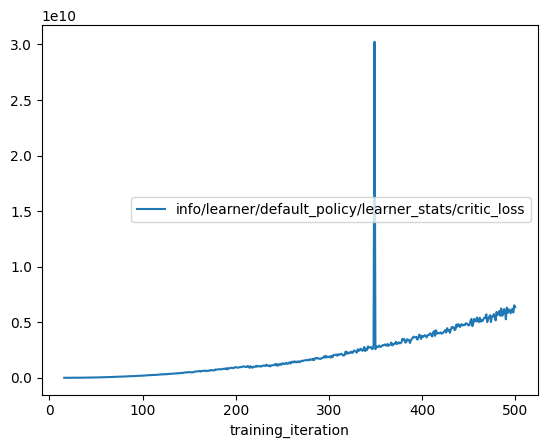

In [19]:
result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/critic_loss")

Visualize alpha loss

<Axes: xlabel='training_iteration'>

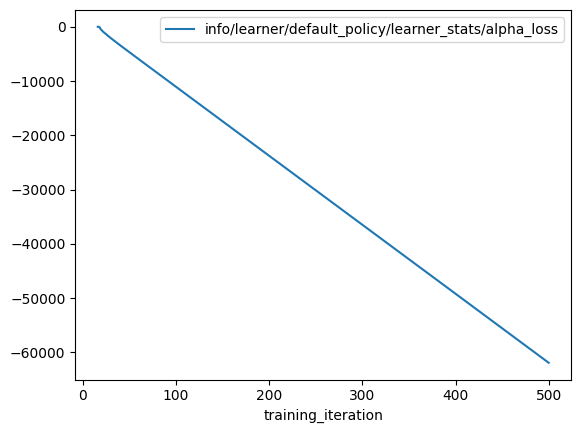

In [20]:
result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/alpha_loss")

Visualize episode reward mean

<Axes: xlabel='training_iteration'>

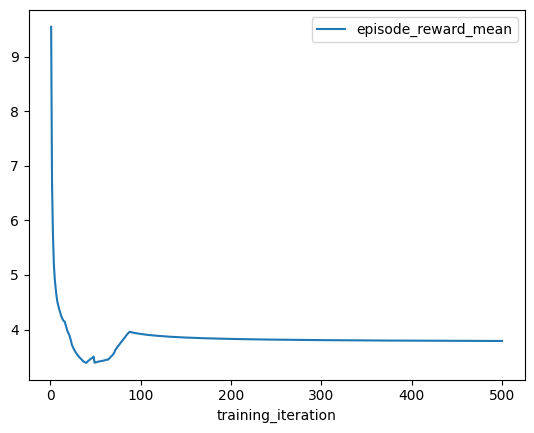

In [21]:
result.metrics_dataframe.plot("training_iteration", "episode_reward_mean")

actor_learning_rate=[0.01, 0.001, 0.0001]

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Mean Test Reward')

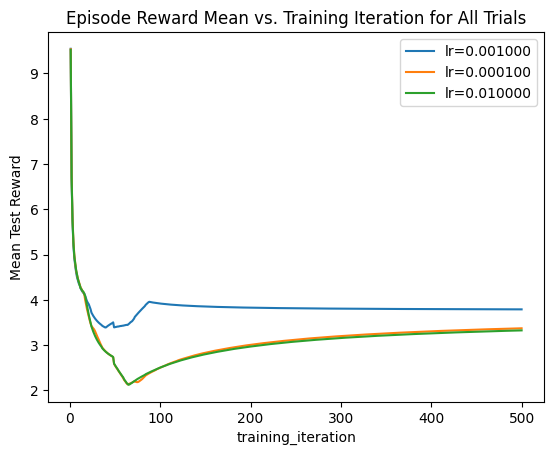

In [26]:
ax = None
for result in result_grid:
    label = f"lr={result.config['optimization']['actor_learning_rate']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "episode_reward_mean", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "episode_reward_mean", ax=ax, label=label)
ax.set_title("Episode Reward Mean vs. Training Iteration for All Trials")
ax.set_ylabel("Mean Test Reward")

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Actor Loss')

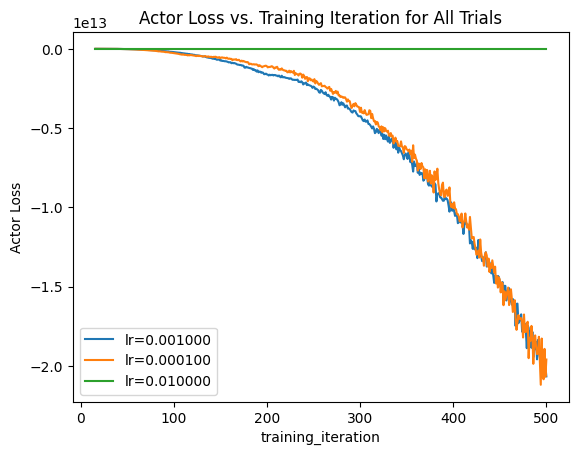

In [27]:
ax = None
for result in result_grid:
    label = f"lr={result.config['optimization']['actor_learning_rate']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/actor_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/actor_loss", ax=ax, label=label)
ax.set_title("Actor Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Actor Loss")

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Critic Loss')

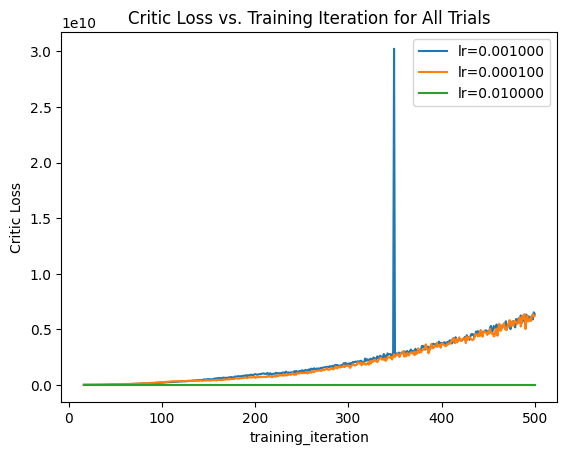

In [28]:
ax = None
for result in result_grid:
    label = f"lr={result.config['optimization']['actor_learning_rate']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/critic_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/critic_loss", ax=ax, label=label)
ax.set_title("Critic Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Critic Loss")

critic_learning_rate=[0.01, 0.001, 0.0001]

In [11]:
experiment_path = os.path.join(storage_path, exp_name)
print(f"Loading results from {experiment_path} ...")

restored_tuner = tune.Tuner.restore(experiment_path, trainable="SAC")
result_grid = restored_tuner.get_results()

Loading results from /content/drive/MyDrive/Colab Notebooks/rllib/ray_results/SAC2_critic_lr ...


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Mean Test Reward')

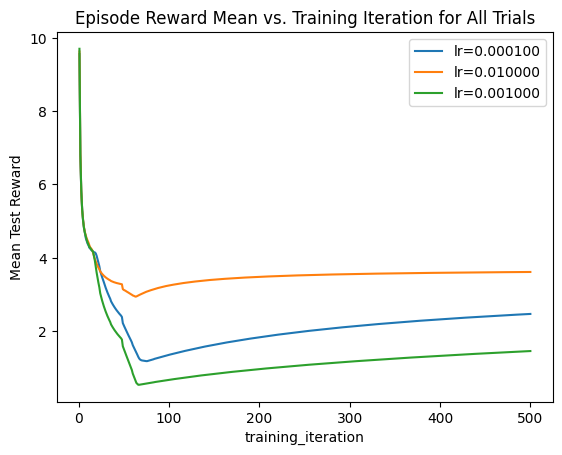

In [13]:
ax = None
for result in result_grid:
    label = f"lr={result.config['optimization']['critic_learning_rate']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "episode_reward_mean", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "episode_reward_mean", ax=ax, label=label)
ax.set_title("Episode Reward Mean vs. Training Iteration for All Trials")
ax.set_ylabel("Mean Test Reward")

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Actor Loss')

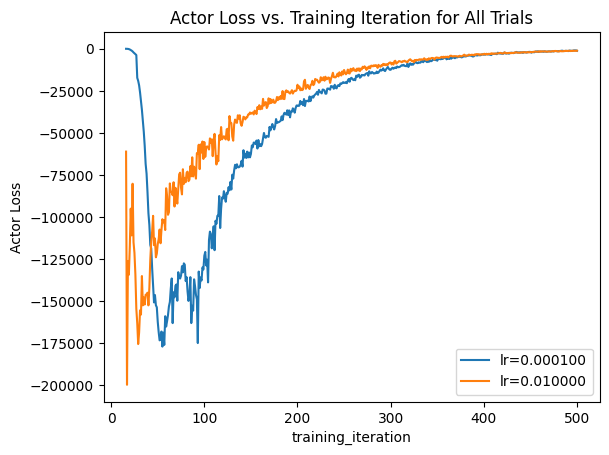

In [18]:
ax = None
for result in result_grid[:2]:
    label = f"lr={result.config['optimization']['critic_learning_rate']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/actor_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/actor_loss", ax=ax, label=label)
ax.set_title("Actor Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Actor Loss")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Text(0, 0.5, 'Critic Loss')

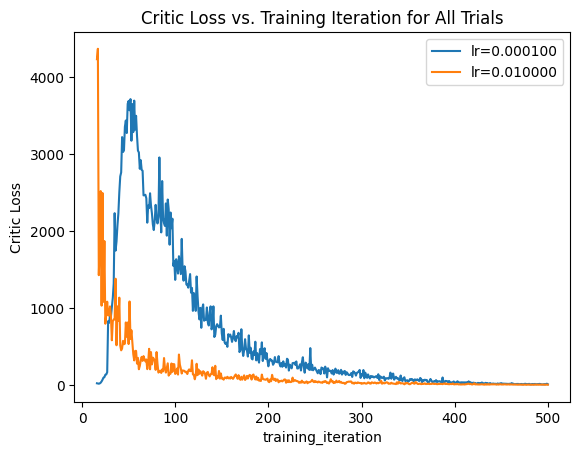

In [19]:
ax = None
for result in result_grid[:2]:
    label = f"lr={result.config['optimization']['critic_learning_rate']:.6f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/critic_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "info/learner/default_policy/learner_stats/critic_loss", ax=ax, label=label)
ax.set_title("Critic Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Critic Loss")